## Step 1: Exploratory Data Analysis (EDA)
🔍 1.1 Create a Python Script for EDA
We kick off the exploration by creating a dedicated Python script to handle EDA. This file acts as the first formal analysis point of the project. By organizing our code here, we keep things modular, repeatable, and clean.

🧾 1. Load the Data
We load the Online Retail II dataset using pandas, carefully using 'latin1' encoding to avoid any import errors caused by special characters. This gives us a raw view of the dataset—rows, columns, and a few sample transactions. It sets the stage for everything that follows.

In [125]:
# eda_online_retail.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Set visualization style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# === 1. Load the Data ===
# Replace the file path if necessary.
data_path = "../data/online_retail_II.csv"
df = pd.read_csv(data_path, encoding='latin1')  # Sometimes these files have latin1 encoding
print("Raw Data Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nSample Data:")
print(df.head())

Raw Data Shape: (1067371, 8)
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

Sample Data:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  



🧼 2. Data Cleaning
Before diving deeper, we need to tidy the data:

We check for missing values, especially Customer ID, which is essential for customer-level analysis.

Rows missing Customer ID are dropped because we cannot associate them with a shopper.

We remove duplicate rows to prevent double-counting.

We filter out cancellations/returns, which are identified by invoices starting with "C", since these do not reflect actual purchases.

Then, we convert data types: converting date strings to datetime, prices to floats, and quantities to integers.

Finally, we create a new TotalPrice column that captures the monetary value of each line item (Quantity × UnitPrice).

In [126]:
print((df.Quantity<0).sum())
print((df.Price<0).sum())

22950
5


In [127]:
# === 2. Data Cleaning ===

# Inspect for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop rows with missing CustomerID since they hinder customer-based analysis.
df = df.dropna(subset=["Customer ID"])
print("Shape after dropping missing Customer ID:", df.shape)

# Remove duplicates
df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)

# Remove cancellations/returns:
# Usually, cancellations have Invoice numbers starting with 'C'
df = df[~df["Invoice"].astype(str).str.startswith("C")]
print("Shape after removing cancellations:", df.shape)

# Remove negative quantities and prices
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]
print("Shape after removing negative quantities and prices:", df.shape)

# Convert data types
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Quantity"] = df["Quantity"].astype(int)
df["Price"] = df["Price"].astype(float)




Missing values per column:
Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64
Shape after dropping missing Customer ID: (824364, 8)
Shape after dropping duplicates: (797885, 8)
Shape after removing cancellations: (779495, 8)
Shape after removing negative quantities and prices: (779425, 8)


2. Outlier Capping & Transformation
The ihsncnkz notebook uses IQR capping on RFM but doesn’t show skew diagnostics before/after .

Monetary and quantity distributions are long‑tailed—apply log or Box–Cox before clustering/regression .

Action:

3. Text Normalization & Whitespace
Product Description and Invoice codes may have leading/trailing spaces, causing phantom categories 
Stack Overflow
.

Action:

In [128]:
# === 3. Text normalization ===
df["Description"] = df["Description"].str.strip()                       # strip whitespace :contentReference[oaicite:7]{index=7}  
df["Invoice"]     = df["Invoice"].str.strip()                           # strip invoice codes :contentReference[oaicite:8]{index=8}  
df["Country"]     = df["Country"].str.title().str.strip()                # normalize country names :contentReference[oaicite:9]{index=9}  
df["Customer ID"] = df["Customer ID"].astype(str).str.strip()


In [129]:
qs = df["Price"].quantile([0.90, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995,0.996,0.997, 0.998,0.999])
print(qs)

0.900     6.75
0.950     8.50
0.960     9.95
0.970     9.95
0.980    12.75
0.990    14.95
0.995    18.00
0.996    18.00
0.997    19.95
0.998    29.95
0.999    49.95
Name: Price, dtype: float64


In [130]:
qs = df["Quantity"].quantile([0.90, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995,0.996,0.997, 0.999])
print(qs)

0.900     24.0
0.950     36.0
0.960     48.0
0.970     50.0
0.980     96.0
0.990    144.0
0.995    208.0
0.996    240.0
0.997    288.0
0.999    576.0
Name: Quantity, dtype: float64


In [131]:
# === 5. Stage 2: Percentile‑trim raw features (95th %ile) ===
for col in ["Quantity","Price"]:
    hi = df[col].quantile(0.95)                                      # high cutoff :contentReference[oaicite:12]{index=12}  
    df = df[df[col] <= hi]                                           # drop top 5 % :contentReference[oaicite:13]{index=13}  


In [132]:
# cap moderate outliers :contentReference[oaicite:11]{index=11}  
# === 4. Stage 1: IQR‑clipping raw features ===
for col in ["Quantity","Price"]:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR    = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR                        # define fences :contentReference[oaicite:10]{index=10}  
    df[col] = df[col].clip(lower, upper) 

In [133]:
qs = df["Price"].quantile([0.90, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995,0.996,0.997, 0.998,0.999])
print(qs)

0.900    5.45
0.950    6.25
0.960    6.25
0.970    6.25
0.980    6.25
0.990    6.25
0.995    6.25
0.996    6.25
0.997    6.25
0.998    6.25
0.999    6.25
Name: Price, dtype: float64


In [134]:
qs = df["Quantity"].quantile([0.90, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995,0.996,0.997, 0.998,0.999])
print(qs)

0.900    20.0
0.950    24.0
0.960    24.0
0.970    25.0
0.980    25.0
0.990    27.0
0.995    27.0
0.996    27.0
0.997    27.0
0.998    27.0
0.999    27.0
Name: Quantity, dtype: float64


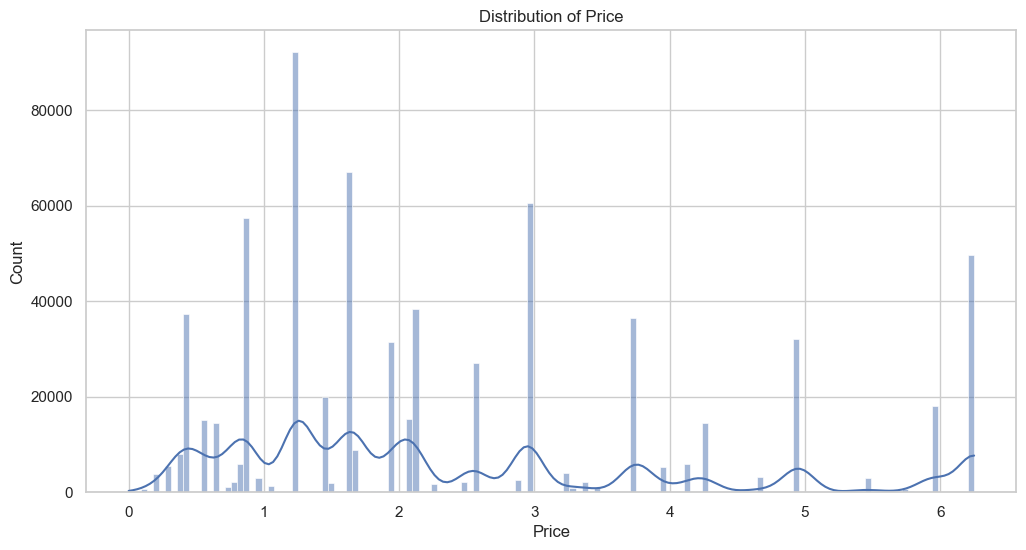

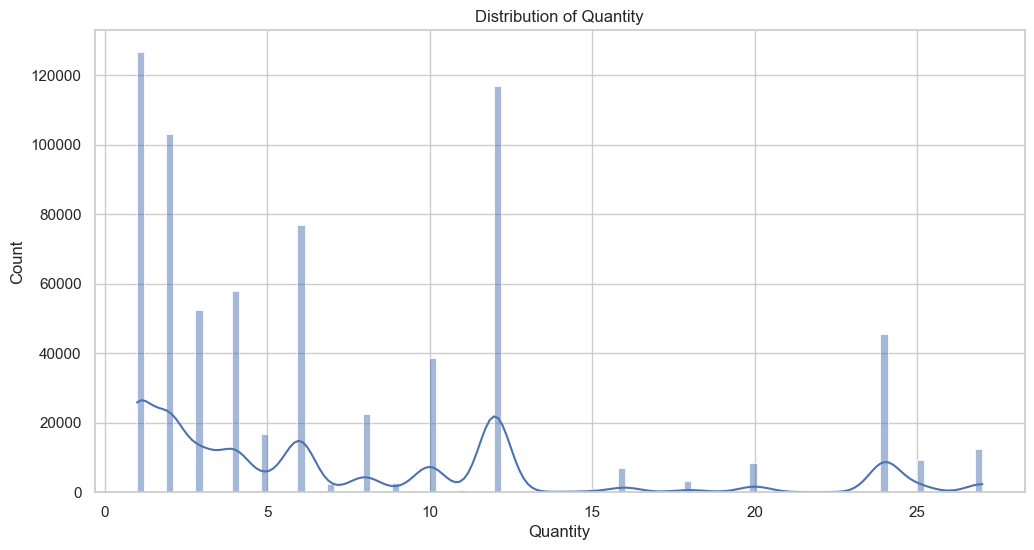

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ["Price", "Quantity"]:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [136]:
# === 6. Create derived feature after raw cleaning ===
df["TotalPrice"] = df["Quantity"] * df["Price"]                      # no new extremes :contentReference[oaicite:14]{index=14}  
print("Shape after creating TotalPrice:", df.shape)

Shape after creating TotalPrice: (705476, 9)


4. Extreme‑High Value Filtering
Even after IQR capping, extremely large TotalPrice entries (e.g. top 0.1 %) can skew models. Neither notebook explicitly filters these 
Kaggle
.

Action:

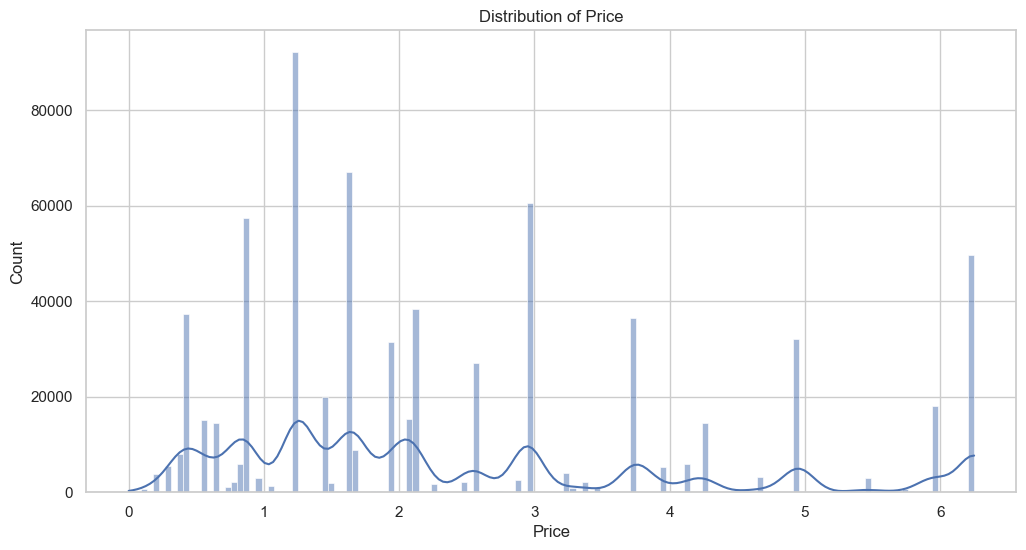

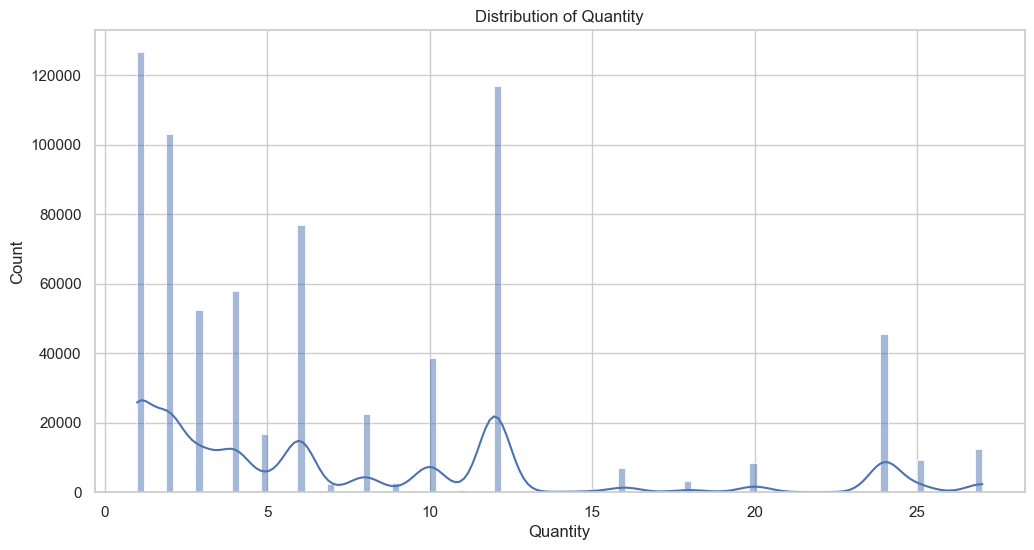

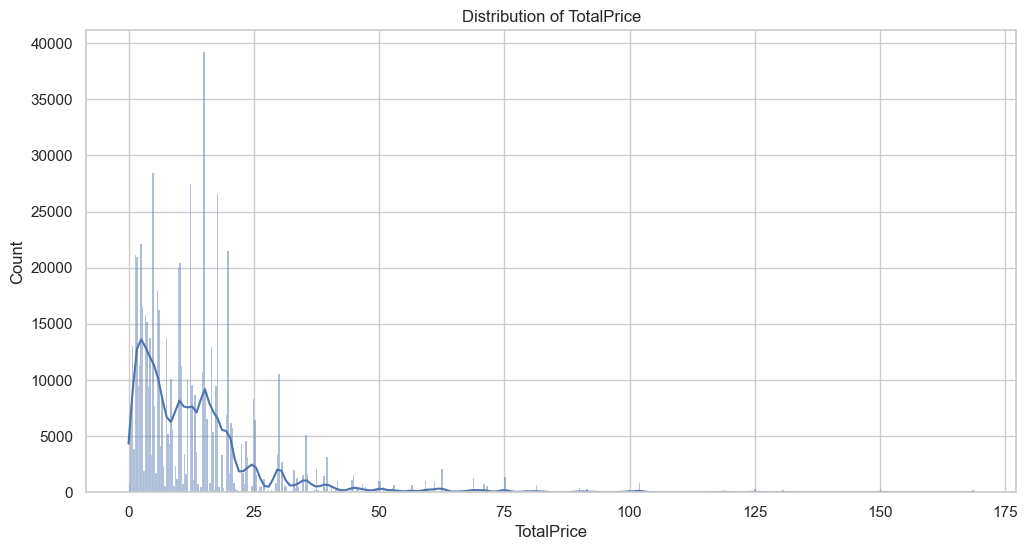

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ["Price", "Quantity", "TotalPrice"]:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


In [138]:
qs = df["TotalPrice"].quantile([0.90, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995,0.996,0.997, 0.998,0.999])
print(qs)


0.900     25.50
0.950     37.50
0.960     40.56
0.970     47.60
0.980     60.00
0.990     75.00
0.995     91.60
0.996    100.00
0.997    102.00
0.998    118.80
0.999    133.65
Name: TotalPrice, dtype: float64


In [139]:

# 7b. Percentile‑trim TotalPrice
hi_tp = df["TotalPrice"].quantile(0.95)
df    = df[df["TotalPrice"] <= hi_tp]                               # drop top 5 % TP :contentReference[oaicite:16]{index=16}  

print("Final cleaned shape:", df.shape)

Final cleaned shape: (671889, 9)


In [140]:
qs = df["TotalPrice"].quantile([0.90, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995,0.996,0.997, 0.998,0.999])
print(qs)
print("Final cleaned shape:", df.shape)


0.900    22.5
0.950    29.5
0.960    30.0
0.970    30.0
0.980    33.0
0.990    35.4
0.995    35.7
0.996    35.7
0.997    37.5
0.998    37.5
0.999    37.5
Name: TotalPrice, dtype: float64
Final cleaned shape: (671889, 9)


In [141]:
# === 7. Clean derived feature ===
# 7a. IQR‑clip TotalPrice
Q1, Q3 = df["TotalPrice"].quantile([0.25, 0.75])
IQR    = Q3 - Q1
df["TotalPrice"] = df["TotalPrice"].clip(Q1-1.5*IQR, Q3+1.5*IQR)     # cap moderate TP outliers :contentReference[oaicite:15]{index=15}  

In [142]:
qs = df["TotalPrice"].quantile([0.90, 0.95, 0.99, 0.995, 0.999])
print(qs)


0.900    22.50
0.950    29.50
0.990    35.01
0.995    35.01
0.999    35.01
Name: TotalPrice, dtype: float64


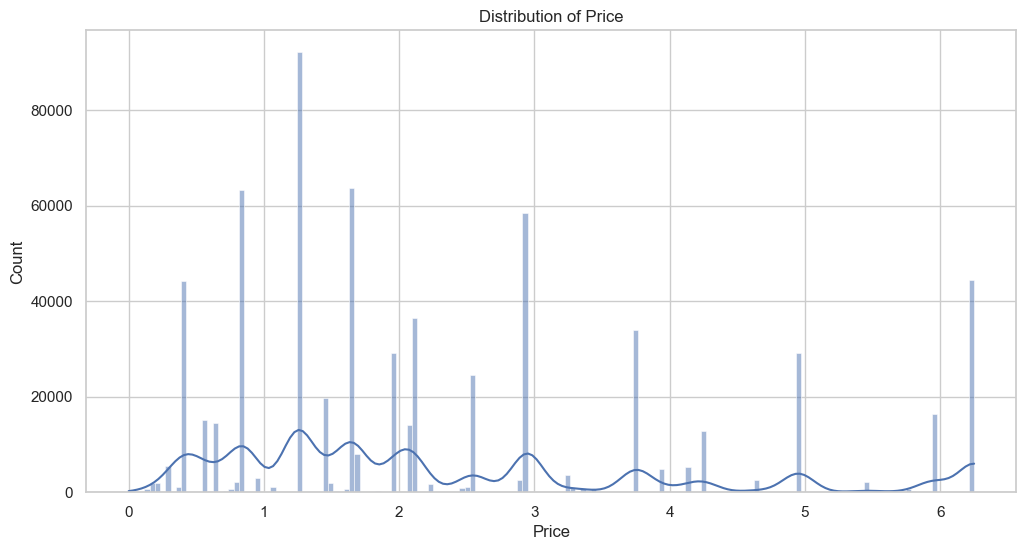

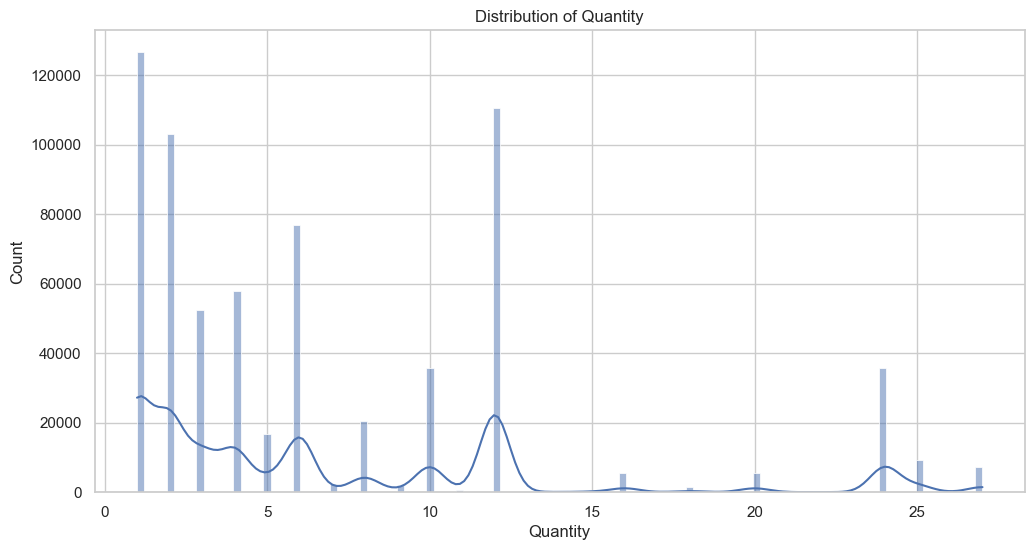

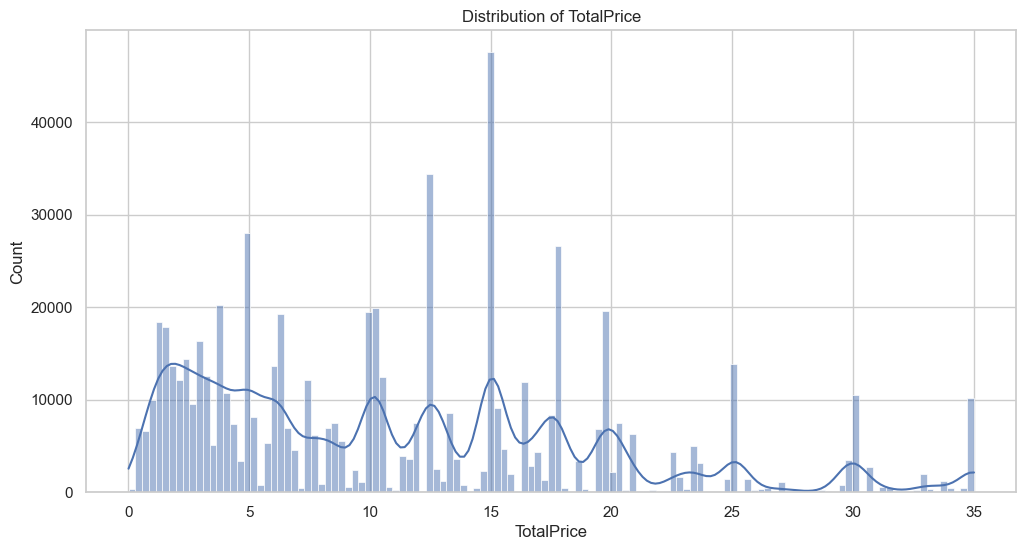

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ["Price", "Quantity", "TotalPrice"]:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


Quantity      1.408221
Price         1.008200
TotalPrice    0.826012
dtype: float64


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
1067295,581579,23344,JUMBO BAG 50'S CHRISTMAS,20,2011-12-09 12:19:00,1.79,17581.0,United Kingdom,35.01
102705,499228,22090,PAPER BUNTING RETRO SPOTS,12,2010-02-25 12:01:00,2.95,17863.0,United Kingdom,35.01
102803,499231,21733,RED HANGING HEART T-LIGHT HOLDER,12,2010-02-25 12:18:00,2.95,15674.0,United Kingdom,35.01
102571,499223,84676,BATH DUCK WATERING CAN,12,2010-02-25 11:45:00,2.95,12583.0,France,35.01
1067293,581579,23201,JUMBO BAG ALPHABET,20,2011-12-09 12:19:00,1.79,17581.0,United Kingdom,35.01
270528,515598,21452,TOADSTOOL MONEY BOX,12,2010-07-13 14:07:00,2.95,14895.0,United Kingdom,35.01
415755,529130,20914,SET/5 RED SPOTTY LID GLASS BOWLS,12,2010-10-26 14:38:00,2.95,16258.0,United Kingdom,35.01
416131,529149,22457,NATURAL SLATE HEART CHALKBOARD,12,2010-10-26 16:02:00,2.95,17346.0,United Kingdom,35.01
846966,565150,85099F,JUMBO BAG STRAWBERRY,20,2011-09-01 14:26:00,1.79,14298.0,United Kingdom,35.01
846965,565150,85099C,JUMBO BAG BAROQUE BLACK WHITE,20,2011-09-01 14:26:00,1.79,14298.0,United Kingdom,35.01


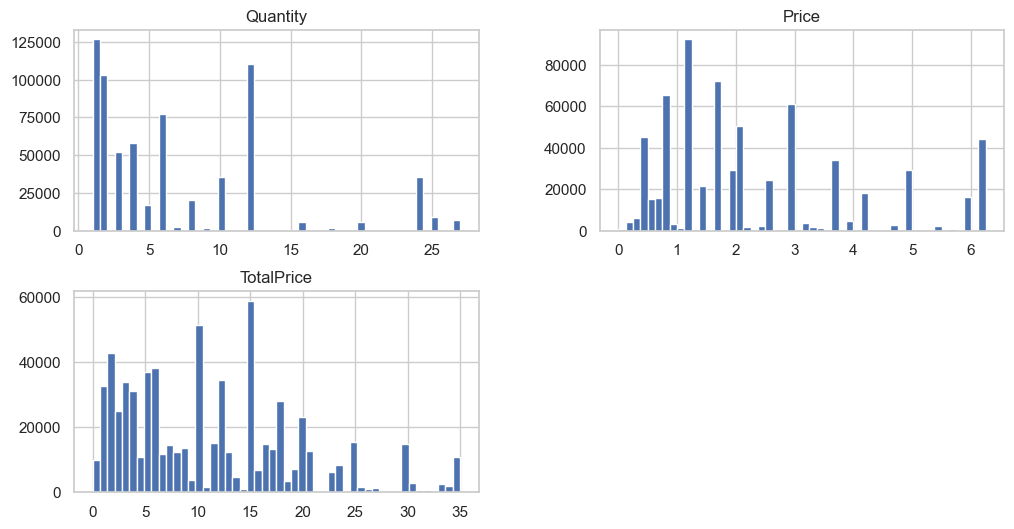

In [144]:
# Histograms / boxplots for outliers
df[["Quantity", "Price", "TotalPrice"]].hist(bins=50)
sns.boxplot(data=df[["Quantity", "Price", "TotalPrice"]])

# Check skewness
print(df[["Quantity", "Price", "TotalPrice"]].skew())

# Check top customers / transactions
df.sort_values("TotalPrice", ascending=False).head(10)


🧱 3. Feature Engineering
We build a new dataset based on RFM Analysis, a classic customer segmentation method:

Recency: How many days ago the customer last made a purchase.

Frequency: How many unique invoices they’ve been part of.

Monetary: How much money they’ve spent overall.

This step transforms our data from transaction-level to customer-level—crucial for personalization and behavior modeling later on.

In [145]:

# === 3. Feature Engineering ===

# Create an RFM (Recency, Frequency, Monetary) analysis frame for customers
snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency: days since last purchase
    "Invoice": "nunique",  # Frequency: count of unique invoices
    "TotalPrice": "sum"    # Monetary: total spend
}).reset_index()
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

📊 4. Data Visualization
📦 4.1 Overall Data Distributions
We visualize the basic distribution of core numeric fields:

Quantity: How many units are purchased per line item.

Unit Price: The price per item—great for identifying low-end vs premium products.

Total Price: Total value per transaction line, giving us a peek into high- vs low-value purchases.

These histograms help us understand patterns, skewness, and detect anomalies like extreme values or price errors.

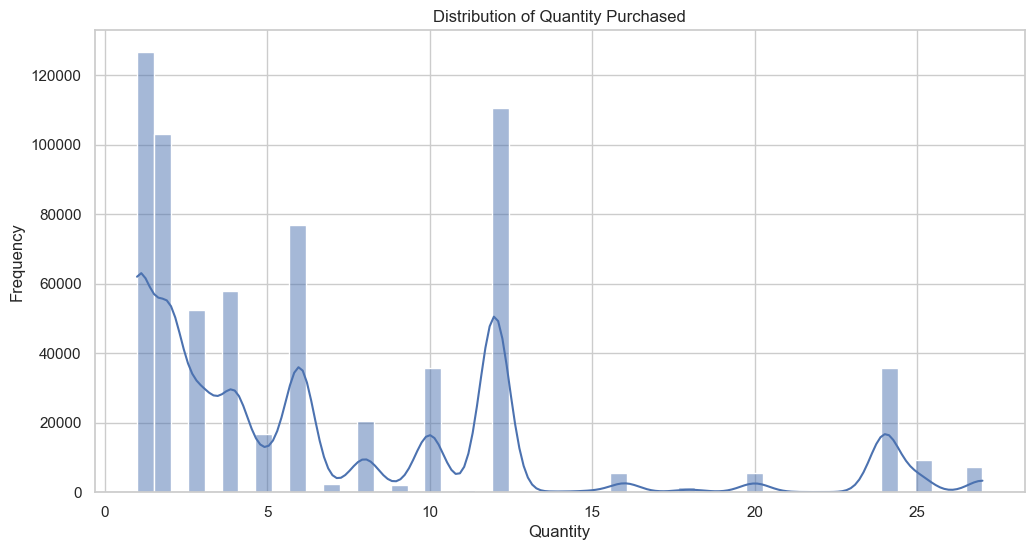

In [146]:
# === 4. Data Visualization ===

## 4.1 Overall Data Distributions

# Distribution of Quantity
plt.figure()
sns.histplot(df["Quantity"], bins=50, kde=True)
plt.title("Distribution of Quantity Purchased")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.savefig("../notebooks/plots/quantity_distribution.png")
plt.show()

💬 Explanation:
This initial plot shows the distribution of Quantity purchased across all transactions. However, it appears heavily skewed, with most values squashed on the left of the x-axis.

This distortion is caused by extreme outliers in the dataset — a few purchases have extremely high quantities (some even over 80,000 units) while the vast majority are small values (like 1 to 10).

As a result, the scale is dominated by these rare large values, and we can’t clearly see the shape of the common purchase distribution.

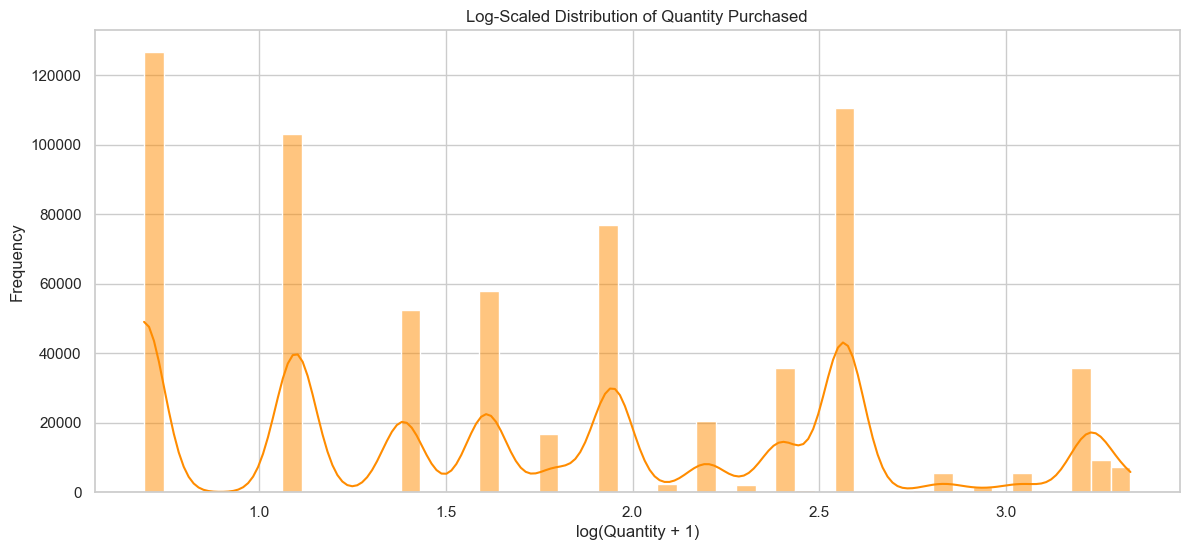

In [147]:
import numpy as np

# Filter only positive quantities to apply log safely
df_pos = df[df["Quantity"] > 0].copy()
df_pos["log_quantity"] = np.log1p(df_pos["Quantity"])  # log(1 + x)

plt.figure(figsize=(14, 6))
sns.histplot(df_pos["log_quantity"], bins=50, kde=True, color="darkorange")
plt.title("Log-Scaled Distribution of Quantity Purchased")
plt.xlabel("log(Quantity + 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


💬 Explanation:
To fix the skewed view, we applied a log transformation using log(Quantity + 1). This compresses large values and spreads out smaller ones, making it easier to visualize the underlying distribution.

Now we can see that most purchases are clustered in the lower quantity range, and the curve shows a right-skewed distribution — still imbalanced, but readable.

This technique is useful in exploratory data analysis (EDA) when dealing with highly skewed numerical data.

❗ Why Did My Plot Look Broken? Because outliers matter. A few massive orders distorted the view.

🛠 Solution? Use log-scale to normalize the scale, then visualize again.

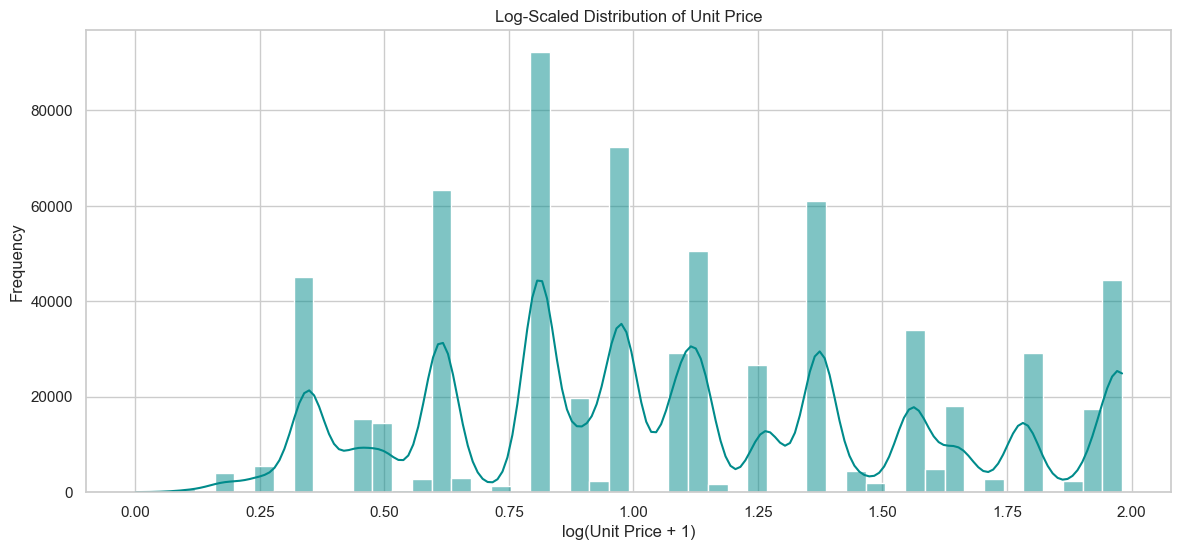

In [148]:
df_pos_price = df[df["Price"] > 0].copy()
df_pos_price["log_price"] = np.log1p(df_pos_price["Price"])

plt.figure(figsize=(14, 6))
sns.histplot(df_pos_price["log_price"], bins=50, kde=True, color="darkcyan")
plt.title("Log-Scaled Distribution of Unit Price")
plt.xlabel("log(Unit Price + 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

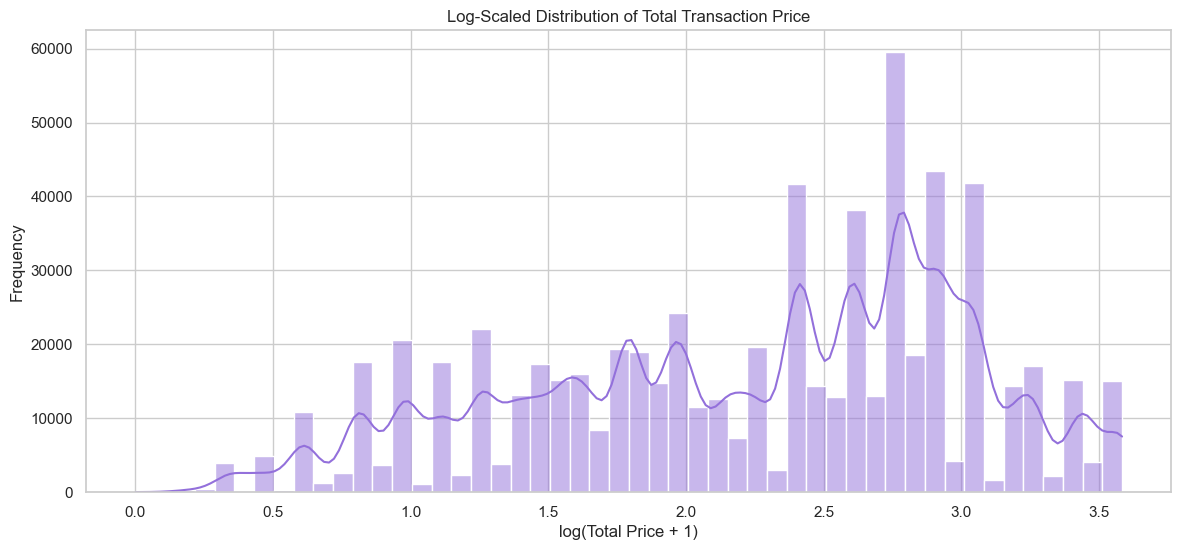

In [149]:
df_pos_total = df[df["TotalPrice"] > 0].copy()
df_pos_total["log_total"] = np.log1p(df_pos_total["TotalPrice"])

plt.figure(figsize=(14, 6))
sns.histplot(df_pos_total["log_total"], bins=50, kde=True, color="mediumpurple")
plt.title("Log-Scaled Distribution of Total Transaction Price")
plt.xlabel("log(Total Price + 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

💬 Explanation:
Applying a log transformation helps normalize the scale, revealing the underlying shape. The distribution is still slightly skewed but now provides a clear view of price tiers across products.








👥 4.2 Customer Segmentation (RFM Analysis)
With the RFM table created, we explore the distributions of each component:

Some customers haven’t purchased in a while (high Recency),

Some are frequent shoppers (high Frequency),

And some spend big (high Monetary).

We also visualize the correlation heatmap between R, F, and M—this helps us spot if any patterns exist (e.g., do frequent buyers spend more?).







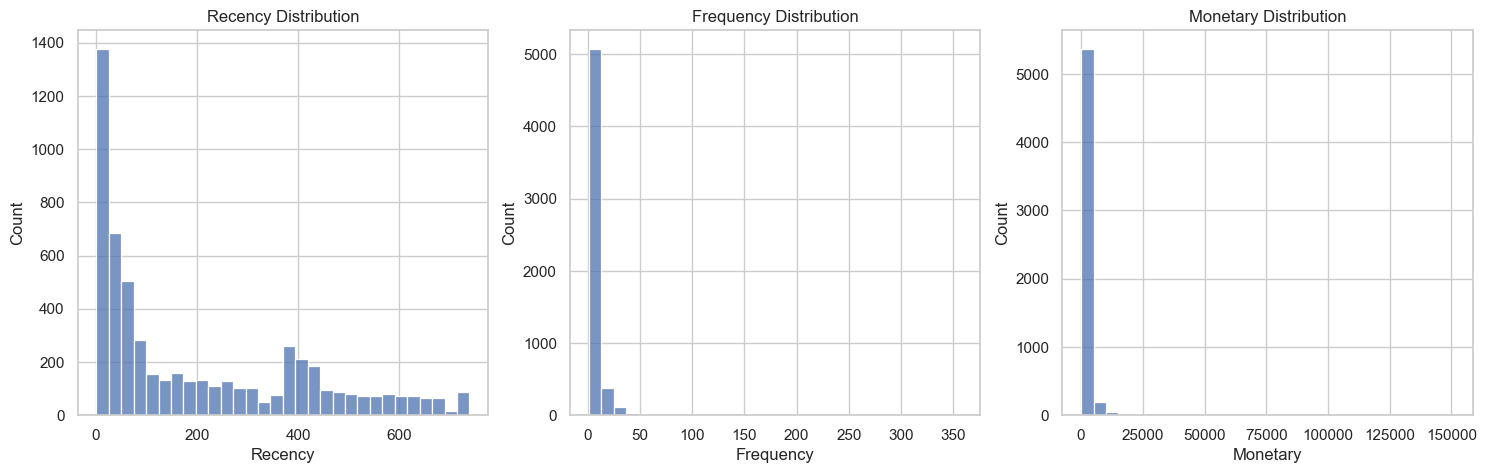

In [150]:
## 4.2 Customer Segmentation (RFM Analysis)

# Plot histograms for RFM values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm["Recency"], bins=30, ax=axes[0])
axes[0].set_title("Recency Distribution")
sns.histplot(rfm["Frequency"], bins=30, ax=axes[1])
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm["Monetary"], bins=30, ax=axes[2])
axes[2].set_title("Monetary Distribution")
plt.savefig("plots/rfm_distributions.png")
plt.show()

In [151]:
for col in ["Recency","Frequency","Monetary"]:
    qs = rfm[col].quantile([0.90, 0.95, 0.99, 0.999])
    print(col, qs.to_dict())


Recency {0.9: 534.0, 0.95: 622.0, 0.99: 726.0, 0.999: 738.0}
Frequency {0.9: 12.0, 0.95: 19.0, 0.99: 41.0, 0.999: 157.1780000000017}
Monetary {0.9: 3185.3380000000006, 0.95: 4847.831499999995, 0.99: 10503.883200000018, 0.999: 34158.3567700009}


In [152]:

""" Trying to scale the RFM values to see if it helps with clustering


from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm.columns)


# Plot histograms for RFM values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm_scaled["Recency"], bins=30, ax=axes[0])
axes[0].set_title("Recency Distribution")
sns.histplot(rfm_scaled["Frequency"], bins=30, ax=axes[1])
axes[1].set_title("Frequency Distribution")
sns.histplot(rfm_scaled["Monetary"], bins=30, ax=axes[2])
axes[2].set_title("Monetary Distribution")
plt.savefig("plots/rfm_distributions.png")
plt.show()



for col in ["Recency","Frequency","Monetary"]:
    qs = rfm_scaled[col].quantile([0.90, 0.95, 0.99, 0.999])
    print(col, qs.to_dict())
"""

' Trying to scale the RFM values to see if it helps with clustering\n\n\nfrom sklearn.preprocessing import RobustScaler\nscaler = RobustScaler()\nrfm_scaled = scaler.fit_transform(rfm)\nrfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm.columns)\n\n\n# Plot histograms for RFM values\nfig, axes = plt.subplots(1, 3, figsize=(18, 5))\nsns.histplot(rfm_scaled["Recency"], bins=30, ax=axes[0])\naxes[0].set_title("Recency Distribution")\nsns.histplot(rfm_scaled["Frequency"], bins=30, ax=axes[1])\naxes[1].set_title("Frequency Distribution")\nsns.histplot(rfm_scaled["Monetary"], bins=30, ax=axes[2])\naxes[2].set_title("Monetary Distribution")\nplt.savefig("plots/rfm_distributions.png")\nplt.show()\n\n\n\nfor col in ["Recency","Frequency","Monetary"]:\n    qs = rfm_scaled[col].quantile([0.90, 0.95, 0.99, 0.999])\n    print(col, qs.to_dict())\n'

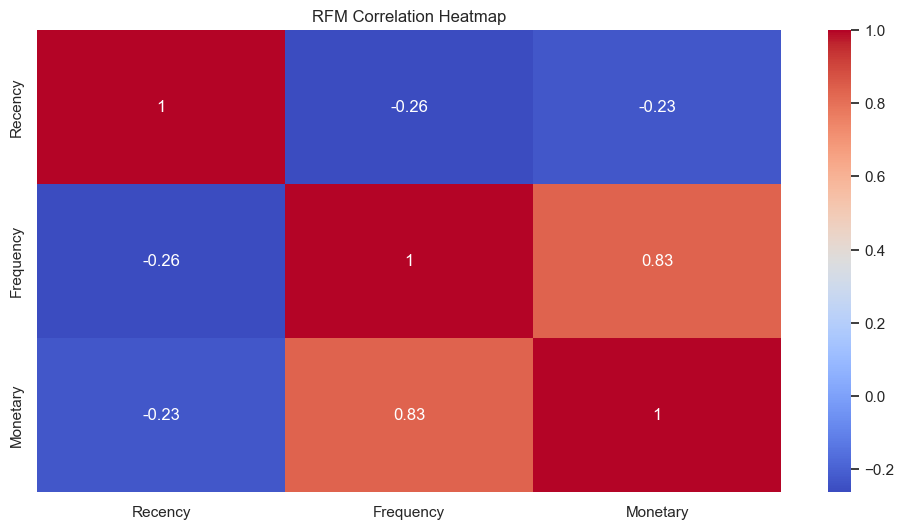

In [153]:
# Correlation heatmap for RFM
plt.figure()
corr = rfm[["Recency", "Frequency", "Monetary"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("RFM Correlation Heatmap")
plt.savefig("plots/rfm_correlation.png")
plt.show()

📈 4.3 Sales Over Time
Here we zoom out to the business level. By aggregating total sales by month, we create a monthly trend line. This helps spot:

Peaks and dips in sales,

Seasonality (e.g., holidays),

Business performance over time.

It’s a powerful way to inform inventory planning and marketing calendars.



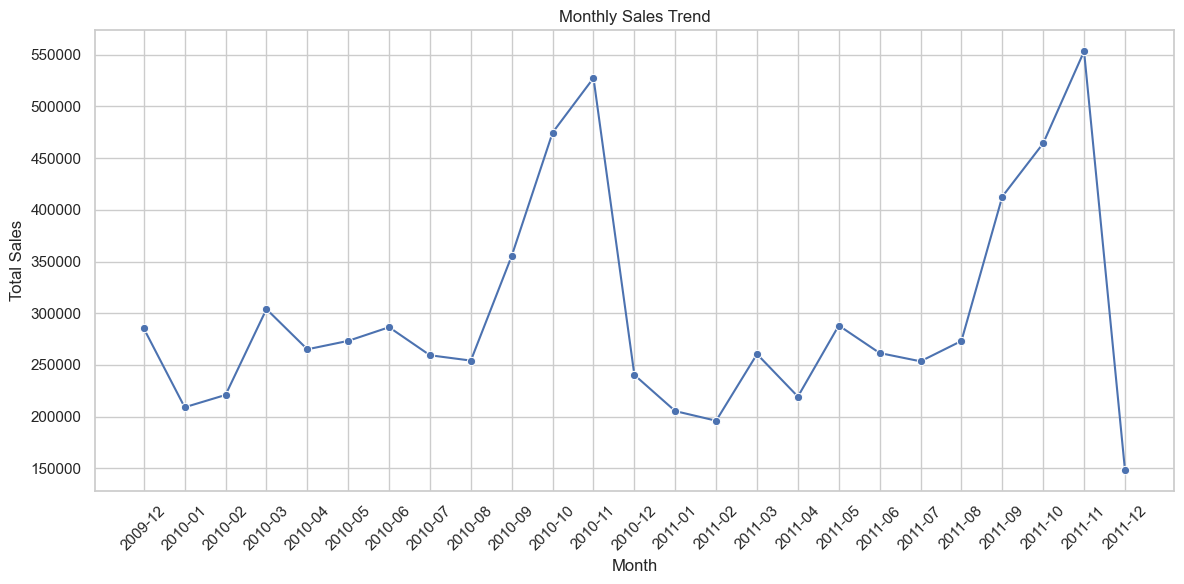

In [154]:
## 4.3 Sales Over Time

# Aggregate sales per month
df["Month"] = df["InvoiceDate"].dt.to_period("M")
monthly_sales = df.groupby("Month")["TotalPrice"].sum().reset_index()
monthly_sales["Month"] = monthly_sales["Month"].astype(str)

plt.figure()
sns.lineplot(data=monthly_sales, x="Month", y="TotalPrice", marker="o")
plt.xticks(rotation=45)
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.savefig("plots/monthly_sales.png")
plt.show()

🌍 4.4 Top Countries by Sales
By grouping sales by country, we identify where the business is thriving and which regions bring the most revenue. This helps in market prioritization, logistics, and even localized promotions.

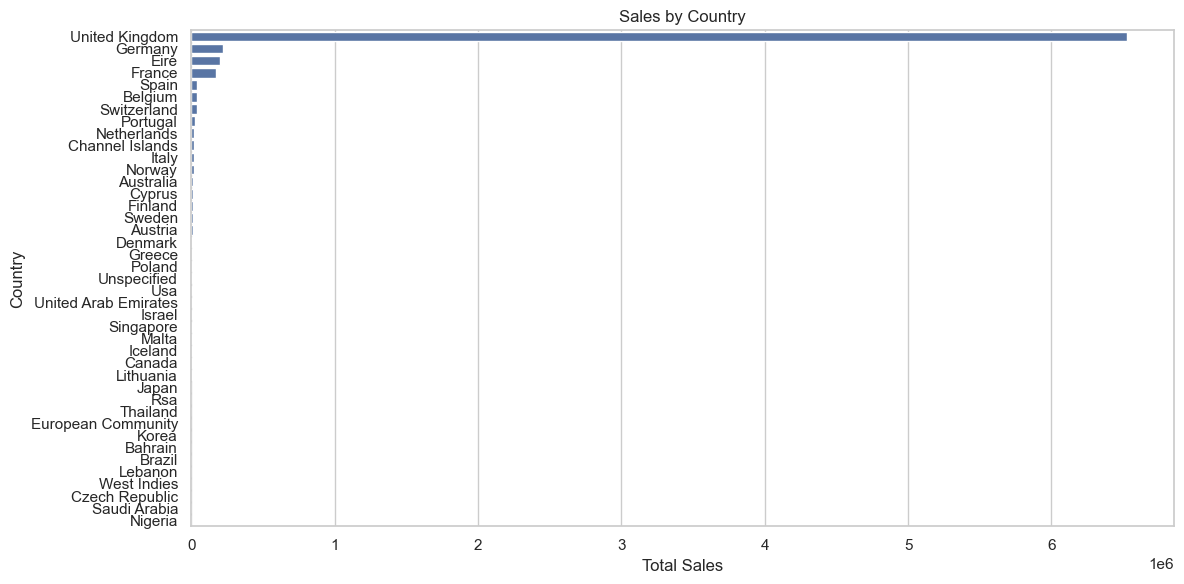

In [155]:

# Sales by Country
country_sales = df.groupby("Country")["TotalPrice"].sum().reset_index().sort_values(by="TotalPrice", ascending=False)
plt.figure()
sns.barplot(data=country_sales, x="TotalPrice", y="Country")
plt.title("Sales by Country")
plt.xlabel("Total Sales")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig("plots/country_sales.png")
plt.show()



🏆 4.5 Top 10 Products (by Total Price)
Finally, we look at the top-performing products based on total revenue. This is essential for product strategy—knowing your best sellers lets you optimize stock, create bundles, or highlight them in marketing campaigns.

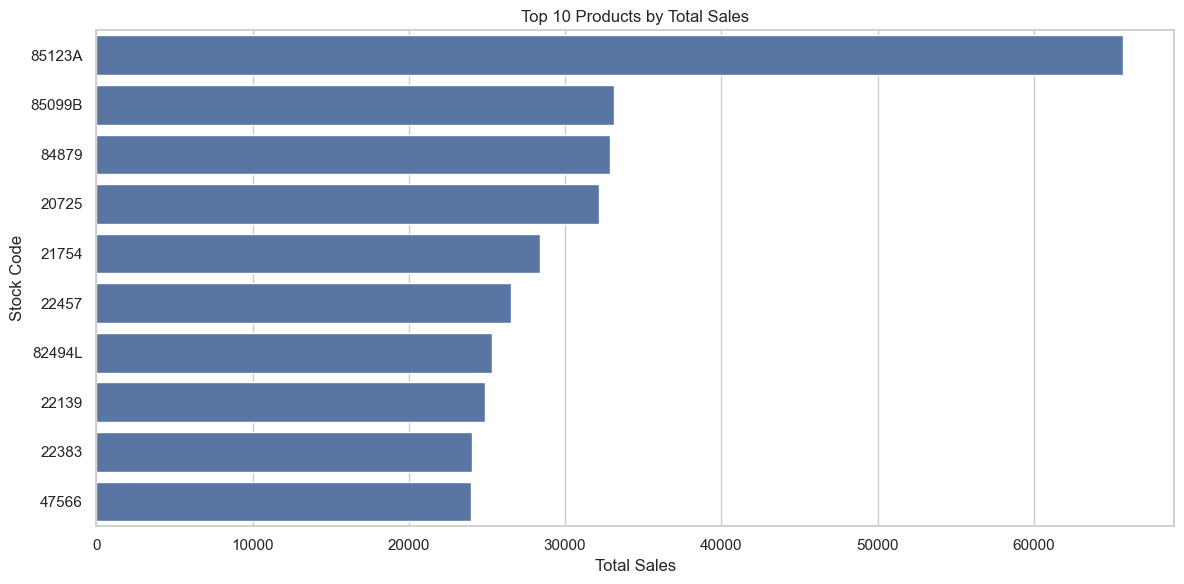

In [156]:
## 4.5 Top 10 Products (by Total Price)
# Assuming "StockCode" represents products. You can use "Description" if available.
top_products = df.groupby("StockCode")["TotalPrice"].sum().reset_index().sort_values(by="TotalPrice", ascending=False).head(10)
plt.figure()
sns.barplot(data=top_products, x="TotalPrice", y="StockCode")
plt.title("Top 10 Products by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Stock Code")
plt.tight_layout()
plt.savefig("plots/top_products.png")
plt.show()

💾 5. Save the Processed Data
We wrap up by saving two key files:

The cleaned transaction dataset: transactions_clean.csv

The customer-level RFM summary: rfm_summary.csv

These files are ready to be used in further analysis, dashboards, machine learning models, or AI-powered search/chat interfaces.

✅ All plots have been saved into a plots/ folder for reporting and presentation use.

In [157]:
# Save the cleaned transactions and RFM summary for later steps
df.to_csv("../data/transactions_clean.csv", index=False)
rfm.to_csv("../data/rfm_summary.csv", index=False)
print("✅ EDA complete. Processed data saved and plots generated in the 'plots/' folder.")

✅ EDA complete. Processed data saved and plots generated in the 'plots/' folder.


In [158]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Month
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009-12
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009-12
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.60,2009-12
11,489435,22353,LUNCHBOX WITH CUTLERY FAIRY CAKES,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,30.60,2009-12
14,489436,21754,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.95,13078.0,United Kingdom,17.85,2009-12
15,489436,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.69,13078.0,United Kingdom,27.04,2009-12
16,489436,22119,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.25,13078.0,United Kingdom,18.75,2009-12
17,489436,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-01 09:06:00,1.45,13078.0,United Kingdom,17.40,2009-12
18,489436,22296,HEART IVORY TRELLIS LARGE,12,2009-12-01 09:06:00,1.65,13078.0,United Kingdom,19.80,2009-12
19,489436,22295,HEART FILIGREE DOVE LARGE,12,2009-12-01 09:06:00,1.65,13078.0,United Kingdom,19.80,2009-12


In [159]:
rfm.head(10)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,529,10,304.30
1,12347.0,2,8,3448.60
2,12348.0,249,4,312.36
3,12349.0,19,3,2597.12
4,12350.0,310,1,294.40
5,12351.0,375,1,288.18
6,12352.0,36,9,1536.10
7,12353.0,204,2,307.46
8,12354.0,232,1,763.03
9,12355.0,214,2,497.71
